# PyGreentea Network Generator 

### Load the dependencies

In [1]:
%matplotlib inline

from __future__ import print_function
import h5py
import numpy as np
from numpy import float32, int32, uint8, dtype
import sys
import matplotlib.pyplot as plt
import copy

pygt_path = '../PyGreentea'
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), pygt_path))

import math

import PyGreentea as pygt

/media/c_drive/Users/Fabian/Documents/ETH/BachelorThesis/eth_bsc/caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import \
/media/c_drive/Users/Fabian/Documents/ETH/BachelorThesis/eth_bsc/caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import \
/media/c_drive/Users/Fabian/Documents/ETH/BachelorThesis/eth_bsc/caffe_gt/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import \


### Load the default network template

In [2]:
netconf = pygt.netgen.NetConf()

### Set the memory limits for the GPU

In [3]:
# We use cuDNN, so:
netconf.ignore_conv_buffer = True
# 4 GB total, ignore convolution buffer. Let's keep 0.5 GB for implementation dependent buffers.
netconf.mem_global_limit = 3.5 * 1024 * 1024 * 1024
# 4 GB convolution buffer limit
netconf.mem_buf_limit = 3.5 * 1024 * 1024 * 1024

### Explore possible network input/output shapes for the chosen settings

In [4]:
# We test memory usage for training
mode = pygt.netgen.caffe_pb2.TRAIN
# The minimum we're interested in
shape_min = [100,100,100]
# And maximum
shape_max = [200,200,200]
# We want Z == X == Y constrained
constraints = [None, lambda x: x[0], lambda x: x[1]]

# Create a network with no context loss (at least for training)
netconf.u_netconfs[0].use_deconvolution_uppath = True
# Create a W-Net (two U-Nets concatenated)
netconf.u_netconfs += [copy.deepcopy(netconf.u_netconfs[0])]

# Run a shortcut (deep residual, additive) over the first U-Net
netconf.u_netconfs[0].bridge = True

# Run a shortcut (deep residual, additive) over the second U-Net
netconf.u_netconfs[1].bridge = True

# Compute (can be quite intensive)
inshape, outshape, fmaps = pygt.netgen.compute_valid_io_shapes(netconf,mode,shape_min,shape_max,constraints=constraints)

++++ Valid: [100] => [100]
-- Invalid: [101] => []
-- Invalid: [102] => []
-- Invalid: [103] => []
-- Invalid: [104] => []
-- Invalid: [105] => []
-- Invalid: [106] => []
-- Invalid: [107] => []
++++ Valid: [108] => [108]
-- Invalid: [109] => []
-- Invalid: [110] => []
-- Invalid: [111] => []
-- Invalid: [112] => []
-- Invalid: [113] => []
-- Invalid: [114] => []
-- Invalid: [115] => []
++++ Valid: [116] => [116]
-- Invalid: [117] => []
-- Invalid: [118] => []
-- Invalid: [119] => []
-- Invalid: [120] => []
-- Invalid: [121] => []
-- Invalid: [122] => []
-- Invalid: [123] => []
++++ Valid: [124] => [124]
-- Invalid: [125] => []
-- Invalid: [126] => []
-- Invalid: [127] => []
-- Invalid: [128] => []
-- Invalid: [129] => []
-- Invalid: [130] => []
-- Invalid: [131] => []
++++ Valid: [132] => [132]
-- Invalid: [133] => []
-- Invalid: [134] => []
-- Invalid: [135] => []
-- Invalid: [136] => []
-- Invalid: [137] => []
-- Invalid: [138] => []
-- Invalid: [139] => []
++++ Valid: [140] => [140

### Visualization

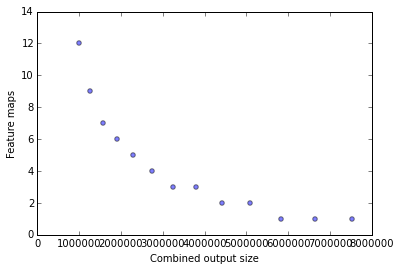

In [5]:
plt.figure()
# Combined output size versus feature map count
plt.scatter([x[0]*x[1]*x[2] for x in outshape], fmaps, alpha = 0.5)
plt.ylabel('Feature maps')
plt.xlabel('Combined output size')
plt.show()

### Pick parameters, actually generate and store the network

In [6]:
netconf.input_shape = inshape[0]
netconf.output_shape = outshape[0]
netconf.fmap_start = fmaps[0]

print ('Input shape: %s' % netconf.input_shape)
print ('Output shape: %s' % netconf.output_shape)
print ('Feature maps: %s' % netconf.fmap_start)

netconf.loss_function = "euclid"
train_net_conf_euclid, test_net_conf = pygt.netgen.create_nets(netconf)
netconf.loss_function = "malis"
train_net_conf_malis, test_net_conf = pygt.netgen.create_nets(netconf)

with open('net_train_euclid.prototxt', 'w') as f:
    print(train_net_conf_euclid, file=f)
with open('net_train_malis.prototxt', 'w') as f:
    print(train_net_conf_malis, file=f)
with open('net_test.prototxt', 'w') as f:
    print(test_net_conf, file=f)

Input shape: [100, 100, 100]
Output shape: [100, 100, 100]
Feature maps: 12
Shape: [0]
f: 1 w: [100, 100, 100] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [1]
f: 12 w: [98, 98, 98] d: [1, 1, 1]
WM: 1296
CM: 108000000
AM: 96000000
Shape: [2]
f: 12 w: [96, 96, 96] d: [1, 1, 1]
WM: 15552
CM: 1219784832
AM: 90354432
Shape: [3]
f: 12 w: [48, 48, 48] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [4]
f: 36 w: [46, 46, 46] d: [1, 1, 1]
WM: 46656
CM: 143327232
AM: 31850496
Shape: [5]
f: 36 w: [44, 44, 44] d: [1, 1, 1]
WM: 139968
CM: 378442368
AM: 28032768
Shape: [6]
f: 36 w: [22, 22, 22] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [7]
f: 108 w: [20, 20, 20] d: [1, 1, 1]
WM: 419904
CM: 41399424
AM: 9199872
Shape: [8]
f: 108 w: [18, 18, 18] d: [1, 1, 1]
WM: 1259712
CM: 93312000
AM: 6912000
Shape: [9]
f: 108 w: [9, 9, 9] d: [1, 1, 1]
WM: 0
CM: 0
AM: 0
Shape: [10]
f: 324 w: [7, 7, 7] d: [1, 1, 1]
WM: 3779136
CM: 8503056
AM: 1889568
Shape: [11]
f: 324 w: [9, 9, 9] d: [1, 1, 1]
WM: 11337408
CM: 12002256
AM: 889056
Shape